# baby face detection

In [ ]:
# 先建立資料庫
# USE [face]
# GO
# -- 建立資料表 放置使用者上傳圖片資訊
# CREATE TABLE [dbo].[allimage](
#     [id] [int] IDENTITY(1,1) NOT NULL,
#     [image_name] [nvarchar](50) NULL,
#     [date] [datetime] NULL,
#     [user_id] [nvarchar](50) NULL,
#     [img_url_original] [nvarchar](100) NULL,
#     [img_url_face_recognition] [nvarchar](100) NULL,
#     [img_url_dlib] [nvarchar](100) NULL,
#     [img_url_mtcnn] [nvarchar](100) NULL,)
# GO
# -- 建立資料表 放置使用者按讚統計資訊
# CREATE TABLE [dbo].[image_score](
#     [id] [int] IDENTITY(1,1) NOT NULL,
#     [user_id] nvarchar(50) NULL,
#     [img_id] int references allimage(id) NULL,
#     [date] datetime NULL,
#     [face_recognition] int NULL,
#     [dlib] int NULL,
#     [mtcnn] int NULL,)
# GO

# SQL統計資訊指令
# select sum([face_recognition]) as [face_recognition], sum([dlib]) as [dlib], sum([mtcnn]) as [mtcnn]
# from [dbo].[image_score]

firebase已經初始化
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


static\jpg-oigytjof.jpg
original_url = https://storage.googleapis.com/ordersamface.appspot.com/jpg-oigytjof.jpg
fr_url = https://storage.googleapis.com/ordersamface.appspot.com/jpg-oigytjof_face_recognition.jpg
dlib_url = https://storage.googleapis.com/ordersamface.appspot.com/jpg-oigytjof_dlib.jpg
寫入資料庫成功


127.0.0.1 - - [17/Jul/2020 19:30:55] "POST /callback HTTP/1.1" 200 -


static\jpg-veppxy69.jpg
original_url = https://storage.googleapis.com/ordersamface.appspot.com/jpg-veppxy69.jpg
fr_url = https://storage.googleapis.com/ordersamface.appspot.com/jpg-veppxy69_face_recognition.jpg
dlib_url = https://storage.googleapis.com/ordersamface.appspot.com/jpg-veppxy69_dlib.jpg
寫入資料庫成功


127.0.0.1 - - [17/Jul/2020 19:34:05] "POST /callback HTTP/1.1" 200 -
127.0.0.1 - - [17/Jul/2020 19:34:19] "POST /callback HTTP/1.1" 200 -
127.0.0.1 - - [17/Jul/2020 19:34:20] "POST /callback HTTP/1.1" 200 -


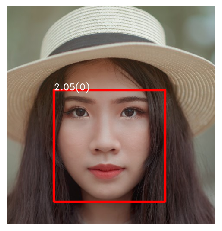

In [5]:
import os, time
from flask import *
import tempfile
from werkzeug.utils import secure_filename

import firebase_admin
from firebase_admin import credentials, firestore, storage

from linebot import (LineBotApi, WebhookHandler)
from linebot.exceptions import (InvalidSignatureError)
from linebot.models import *

import numpy as np
from matplotlib import pyplot as plt
import cv2
import face_recognition
import dlib

app = Flask(__name__)
# 上傳資料夾設定
app.config['UPLOAD_FOLDER'] = './static/'
# 本機__file__改成'__file__'
static_tmp_path = os.path.join(os.path.dirname('__file__'), 'static')

# SQL Server儲存圖片URL + 統計資訊
import pyodbc
driver = 'ODBC Driver 17 for SQL Server'
server = '127.0.0.1, 1433'
database = 'face'
username = 'sa'
password = 'as'
cnxn = pyodbc.connect('DRIVER={' + driver + '};SERVER=' + 
                      server + ';DATABASE=' + database + ';UID=' + username + ';PWD=' + password)
cursor = cnxn.cursor()

# firebase儲存圖片(URL)
cred = credentials.Certificate('serviceAccount_face.json')    # 你的憑證檔
# firebase storage位置：gs://ordersamlineapp.appspot.com
try:
    firebase_admin.initialize_app(cred, {'storageBucket': '你的firebase storage專案名稱.appspot.com'})
    app01 = firebase_admin.initialize_app(cred, {'storageBucket': '你的firebase storage專案名稱.appspot.com',}, 
                                          name='storage')
except ValueError:
    print('firebase已經初始化')
# 上傳到遠端，回傳檔案網址
def firebase_upload(dist_name, pic_route):
    bucket = storage.bucket(app=app01)
    blob = bucket.blob(dist_name)
    blob.upload_from_filename(pic_route)
    blob.make_public()        # 開放圖片可以讓所有人查看
    return blob.public_url    # 檔案網址

##### --------------------------------演算法-------------------------------- #####
# face_recognition演算法
def face_recognition_func(pic_route):
    image = face_recognition.load_image_file(pic_route)
    # 1.查詢臉部位置=[(左上x, 左上y, 右下x, 右下y)]
    face_locations = face_recognition.face_locations(image)
    # 臉部位置 框
    for face_location in face_locations:
        cv2.rectangle(image, face_locations[0][:2], face_locations[0][-2:], (255, 0, 0), 3)
    # 繪圖
    plt.imshow(image)
    plt.axis('off')
    # 存檔
    name = os.path.splitext(os.path.basename(pic_route))[0] + '_face_recognition.jpg'
    path = pic_route[:pic_route.find(os.path.basename(pic_route))] + name
    plt.savefig(path)
    return name, path
# dlib演算法
def dlib_func(pic_route):
    img = cv2.imread(pic_route)
    # 正面人臉偵測器
    detector = dlib.get_frontal_face_detector()
    # 偵測人臉，輸出分數
        # detector.run
            # 第三個參數：指定分數閾值，超過閾值的偵測結果都會被輸出
        # 回傳值
            # face_rects2：rectangles[第一張臉[(左上x, 左上y) (右下x, 右下y)], ...]
            # scores：[第一張臉 分數, ...]
            # idx：[第一張臉 子偵測器編號, ...] → 子偵測器編號可判斷人臉方向
    face_rects2, scores, idx = detector.run(img, 0, 0)
    # 取出所有偵測的結果
    faces2 = []
    for i, d in enumerate(face_rects2):
        x1 = d.left()
        y1 = d.top()
        x2 = d.right()
        y2 = d.bottom()
        faces2.append([x1, y1, x2, y2])
    # 畫框 + 標示分數
    for i, face in enumerate(faces2):
        cv2.rectangle(img, tuple(face[:2]), tuple(face[-2:]), (0, 0, 255), 4, cv2.LINE_AA)
        text = "%2.2f(%d)" % (scores[i], idx[i])
        cv2.putText(img, text, tuple(face[:2]), cv2.FONT_HERSHEY_DUPLEX, 
                    0.7, (255, 255, 255), 1, cv2.LINE_AA)
    # 繪圖
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.axis('off')
    # 存檔
    name = os.path.splitext(os.path.basename(pic_route))[0] + '_dlib.jpg'
    path = pic_route[:pic_route.find(os.path.basename(pic_route))] + name
    plt.savefig(path)
    return name, path
# MTCNN演算法
    # 注意flask當中跑 keras和tensorflow有版本問題，所以先不做了
from mtcnn.mtcnn import MTCNN
def mtcnn_func(pic_route):
    # 載入圖片
    pixels = cv2.imread(pic_route)
    # MTCNN套件辨識
    detector = MTCNN()
    # 回傳辨識結果=[第1張臉, ..., 第13張臉]
        # 每張臉資訊e.g.
            # {'box': [左上角x, 左上角y, 寬w, 高h],
            #  'confidence': 機率,
            #  'keypoints': {'left_eye': 座標(x, y), 'right_eye': 座標(x, y), 'nose': 座標(x, y), 
            #                'mouth_left': 座標(x, y), 'mouth_right': 座標(x, y)} }
    faces = detector.detect_faces(pixels)     # detector.detect_faces(圖片讀入檔案) → 偵測人臉
    # 臉部畫框
    for result in faces:
        x, y, width, height = result['box']
        cv2.rectangle(pixels, (x, y), (x+width, y+height), (0, 0, 255), 4, cv2.LINE_AA)
        text = "%2.2f" % (result['confidence'])
        cv2.putText(pixels, text, (x, y), cv2.FONT_HERSHEY_DUPLEX, 
                    0.7, (0, 0, 255), 1, cv2.LINE_AA)
    # 繪圖
    pixels_RGB = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
    plt.imshow(pixels_RGB)
    plt.axis('off')
    # 存檔
    name = os.path.splitext(os.path.basename(pic_route))[0] + '_mtcnn.jpg'
    path = pic_route[:pic_route.find(os.path.basename(pic_route))] + name
    plt.savefig(path)
    return name, path
##### --------------------------------演算法-------------------------------- #####

# line
YOUR_CHANNEL_ACCESS_TOKEN = '你的linebot 專案TOKEN'
line_bot_api = LineBotApi(YOUR_CHANNEL_ACCESS_TOKEN)
YOUR_CHANNEL_SECRET = '你的linebot 專案SECRET'
handler = WebhookHandler(YOUR_CHANNEL_SECRET)

@app.route("/callback", methods=['POST'])
def callback():
    # get X-Line-Signature header value
    signature = request.headers['X-Line-Signature']
    # get request body as text
    body = request.get_data(as_text=True)
    app.logger.info("Request body: " + body)
    # handle webhook body
    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        print("Invalid signature. Please check your channel access token/channel secret.")
        abort(400)
    return 'OK'

# 使用者丟文字
@handler.add(MessageEvent, message=TextMessage)
def handle_message(event):
    # 使用者
    profile = line_bot_api.get_profile(event.source.user_id)
    user_id = profile.user_id
    
    msg = event.message.text
    url0 = 'https://github.com/ordersam'
    if msg == '辨識範例':
        # face_test.png
        url1 = url2 = 'https://i.imgur.com/Zu46Hry.png'
        # input.jpg + 辨識結果
        url3 = 'https://i.imgur.com/nOhPm4V.png'
        url4 = 'https://i.imgur.com/yFV4oS9.png'
        url5 = 'https://i.imgur.com/c3KvImB.png'
        url6 = 'https://i.imgur.com/q4YKxzv.png'
        pic_route = './static/face_test.png'
        #face_image = face_recognition_func(pic_route)
        
        image_carousel_template = TemplateSendMessage(
            alt_text='Carousel template',
            template=CarouselTemplate(
                columns=[
                    CarouselColumn(
                        thumbnail_image_url=url3, title='原圖', text='這是原圖',
                        actions=[URIAction(label='這是原圖(點我看大張)', uri=url3), 
                                 PostbackAction(label='喜歡這張圖請點我', data='ping', 
                                                text='寶寶好棒棒'),]),
                    CarouselColumn(
                        thumbnail_image_url=url4, title='face_recognition演算法', text='辨識圖',
                        actions=[URIAction(label='這是原圖(點我看大張)', uri=url4), 
                                 PostbackAction(label='喜歡這個辨識結果請點我', data='ping', 
                                                text='demo.jpg用face_recognition演算法'),]),
                    CarouselColumn(
                        thumbnail_image_url=url5, title='dlib演算法', text='辨識圖',
                        actions=[URIAction(label='這是原圖(點我看大張)', uri=url5), 
                                 PostbackAction(label='喜歡這個辨識結果請點我', data='ping', 
                                                text='demo.jpg用dlib演算法'),]), 
                    CarouselColumn(
                        thumbnail_image_url=url6, title='MTCNN演算法', text='辨識圖',
                        actions=[URIAction(label='這是原圖(點我看大張)', uri=url6), 
                                 PostbackAction(label='喜歡這個辨識結果請點我', data='ping', 
                                                text='demo.jpg用MTCNN演算法'),]), 
                ]))
        line_bot_api.reply_message(event.reply_token, image_carousel_template)
    elif '用face_recognition演算法' in msg:
        if '.jpg' in msg or '.png' in msg:
            # 評選的圖檔名稱
            imgname = msg[:msg.find('用')]
            cursor.execute("select * from allimage as a where image_name = '%s'" % imgname) 
            rows = cursor.fetchall()
            if len(rows) > 0:  # 有在資料庫 寫入統計table(交易制度)
                try:
                    cnxn.autocommit = False
                    params = [(rows[0][0], str(user_id), time.strftime("%Y-%m-%d", time.localtime()), 1, 0, 0)]
                    cursor.executemany(
                        "insert into image_score(img_id, user_id, date, face_recognition, dlib, mtcnn) " + 
                        "values (?, ?, ?, ?, ?, ?)", 
                        params)
                except pyodbc.DatabaseError as err:
                    cnxn.rollback()
                    like_text = '唉呀 資料庫好像哪裡壞了>"<\n' + str(err)
                else:
                    cnxn.commit()
                    like_text = 'face_recognition演算法 感謝您的評選-^w^-'
                finally:
                    cnxn.autocommit = True
            else:              # 沒在資料庫
                like_text = '沒有這張圖啦>"<'
        else:
            like_text = '不要亂打啦>"<'
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text=like_text))
    elif '用dlib演算法' in msg:
        if '.jpg' in msg or '.png' in msg:
            # 評選的圖檔名稱
            imgname = msg[:msg.find('用')]
            cursor.execute("select * from allimage as a where image_name = '%s'" % imgname) 
            rows = cursor.fetchall()
            if len(rows) > 0:  # 有在資料庫 寫入統計table(交易制度)
                try:
                    cnxn.autocommit = False
                    params = [(rows[0][0], str(user_id), time.strftime("%Y-%m-%d", time.localtime()), 0, 1, 0)]
                    cursor.executemany(
                        "insert into image_score(img_id, user_id, date, face_recognition, dlib, mtcnn) " + 
                        "values (?, ?, ?, ?, ?, ?)", 
                        params)
                except pyodbc.DatabaseError as err:
                    cnxn.rollback()
                    like_text = '唉呀 資料庫好像哪裡壞了>"<\n' + str(err)
                else:
                    cnxn.commit()
                    like_text = 'dlib演算法 感謝您的評選-^w^-'
                finally:
                    cnxn.autocommit = True
            else:              # 沒在資料庫
                like_text = '沒有這張圖啦>"<'
        else:
            like_text = '不要亂打啦>"<'
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text=like_text))
    elif '用MTCNN演算法' in msg:
        if '.jpg' in msg or '.png' in msg:
            # 評選的圖檔名稱
            imgname = msg[:msg.find('用')]
            cursor.execute("select * from allimage as a where image_name = '%s'" % imgname) 
            rows = cursor.fetchall()
            if len(rows) > 0:  # 有在資料庫 寫入統計table(交易制度)
                try:
                    cnxn.autocommit = False
                    params = [(rows[0][0], str(user_id), time.strftime("%Y-%m-%d", time.localtime()), 0, 0, 1)]
                    cursor.executemany(
                        "insert into image_score(img_id, user_id, date, face_recognition, dlib, mtcnn) " + 
                        "values (?, ?, ?, ?, ?, ?)", 
                        params)
                except pyodbc.DatabaseError as err:
                    cnxn.rollback()
                    like_text = '唉呀 資料庫好像哪裡壞了>"<\n' + str(err)
                else:
                    cnxn.commit()
                    like_text = 'MTCNN演算法 感謝您的評選-^w^-'
                finally:
                    cnxn.autocommit = True
            else:              # 沒在資料庫
                like_text = '沒有這張圖啦>"<'
        else:
            like_text = '不要亂打啦>"<'
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text=like_text))
    elif msg == '寶寶好棒棒':
        carousel_template_message = TemplateSendMessage(
            alt_text='Carousel template', 
            template=CarouselTemplate(
                columns=[CarouselColumn(thumbnail_image_url='https://i.imgur.com/pHX1jsZ.jpg', 
                                        title='寶寶也有Github哦', text='幫寶寶按星星好嗎', 
                                        actions=[URIAction(label='點我去Github幫寶寶按星', uri=url0)])]))
        line_bot_api.reply_message(event.reply_token, carousel_template_message)
    else:
        carousel_template_message = TemplateSendMessage(
            alt_text='Carousel template', 
            template=CarouselTemplate(
                columns=[CarouselColumn(thumbnail_image_url='https://i.imgur.com/pHX1jsZ.jpg', 
                                        title='歡迎加入寶寶 人臉辨識', text='請上傳圖片 以供辨識', 
                                        actions=[MessageAction(label='辨識範例', text='辨識範例', 
                                                               image_url='https://i.imgur.com/tqUlzuS.png')])]))
        line_bot_api.reply_message(event.reply_token, carousel_template_message)
    
# 使用者丟文字以外：Other Message Type(圖檔會自動轉jpg)
@handler.add(MessageEvent, message=(ImageMessage, VideoMessage, AudioMessage))
def handle_content_message(event):
    # 使用者
    profile = line_bot_api.get_profile(event.source.user_id)
    user_id = profile.user_id
    
    # 判斷格式
    if isinstance(event.message, ImageMessage):
        ext = 'jpg'
    elif isinstance(event.message, VideoMessage):
        ext = 'mp4'
    elif isinstance(event.message, AudioMessage):
        ext = 'm4a'
    else:
        return
    # 取得內容
    message_content = line_bot_api.get_message_content(event.message.id)
    with tempfile.NamedTemporaryFile(dir=static_tmp_path, prefix=ext + '-', delete=False) as tf:
        for chunk in message_content.iter_content():
            tf.write(chunk)
        tempfile_path = tf.name

    dist_path = tempfile_path + '.' + ext   # 路徑
    dist_name = os.path.basename(dist_path) # 檔名
    os.rename(tempfile_path, dist_path)     # 目錄名稱 tempfile_path 修改成 dist_path
    # 上傳static的圖片路徑
    pic_route = os.path.join('static', dist_name)
    # 上傳line的http(ngrok)
    getImg = request.host_url + pic_route
    print(pic_route)
    # 將static資料夾內的圖片存檔取出 做辨識 並存檔，回傳 (檔名, 路徑)
    
    name_fr, path_fr = face_recognition_func(pic_route)
    name_dlib, path_dlib = dlib_func(pic_route)
    # 注意flask當中跑 keras和tensorflow有版本問題，所以先不做了
    #name_mtcnn, path_mtcnn = mtcnn_func(pic_route)
    
    # 上傳到遠端(Firebase的Storage)，回傳檔案網址
    original_url = firebase_upload(dist_name, pic_route)
    fr_url = firebase_upload(name_fr, path_fr)
    dlib_url = firebase_upload(name_dlib, path_dlib)
    #mtcnn_url = firebase_upload(name_mtcnn, path_mtcnn)
    print('original_url =', original_url)
    print('fr_url =', fr_url)
    print('dlib_url =', dlib_url)
    
    # 寫入資料庫 
    try:
        cnxn.autocommit = False
        params = [(dist_name, time.strftime("%Y-%m-%d", time.localtime()), str(user_id), 
                   original_url, fr_url, dlib_url)]
        cursor.executemany(
            "insert into allimage" + 
            "(image_name, date, user_id, img_url_original, img_url_face_recognition, img_url_dlib)" + 
            " values (?, ?, ?, ?, ?, ?)", params)
#         params = [(dist_name, time.strftime("%Y-%m-%d", time.localtime()), str(user_id), 
#                    original_url, fr_url, dlib_url, mtcnn_url)]
#         cursor.executemany(
#             "insert into allimage" + 
#             "(image_name, date, user_id, img_url_original, img_url_face_recognition, img_url_dlib, img_url_mtcnn)" + 
#             " values (?, ?, ?, ?, ?, ?, ?)", params)
    except pyodbc.DatabaseError as err:
        cnxn.rollback()
        print('寫入資料庫失敗')
    else:
        cnxn.commit()
        print('寫入資料庫成功')
    finally:
        cnxn.autocommit = True
    
    # line顯示
    image_carousel_template = TemplateSendMessage(
        alt_text='Carousel template',
        template=CarouselTemplate(
            columns=[
                CarouselColumn(
                    thumbnail_image_url=original_url, title='原圖', text='這是原圖', 
                    actions=[URIAction(label='這是原圖(點我看大張)', uri=original_url), 
                             PostbackAction(label='喜歡這張圖請點我', data='ping', 
                                            text='寶寶好棒棒'),]),
                CarouselColumn(
                    thumbnail_image_url=fr_url, title='face_recognition演算法', text='辨識圖',
                    actions=[URIAction(label='這是原圖(點我看大張)', uri=fr_url), 
                             PostbackAction(label='喜歡這個辨識結果請點我', data='ping', 
                                            text=dist_name+'用face_recognition演算法'),]),
                CarouselColumn(
                    thumbnail_image_url=dlib_url, title='dlib演算法', text='辨識圖',
                    actions=[URIAction(label='這是原圖(點我看大張)', uri=dlib_url), 
                             PostbackAction(label='喜歡這個辨識結果請點我', data='ping', 
                                            text=dist_name+'用dlib演算法'),]), 
#                 CarouselColumn(
#                     thumbnail_image_url=mtcnn_url, title='MTCNN演算法', text='辨識圖',
#                     actions=[URIAction(label='這是原圖(點我看大張)', uri=mtcnn_url), 
#                              PostbackAction(label='喜歡這個辨識結果請點我', data='ping', 
#                                             text=dist_name+'用MTCNN演算法'),]), 
            ]))
    line_bot_api.reply_message(event.reply_token, image_carousel_template)
    
if __name__ == "__main__":
    port = int(os.environ.get('PORT', 5000))
    app.run(host='127.0.0.1', port=port)